In [6]:
import range_construction
import flop_classifier
import pandas as pd
import numpy as np
import itertools
import random

from treys import Evaluator, Card, Deck
from joblib import Parallel, delayed

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [7]:
"""
Use monte-carlo simulation to determine an approximate ordering of all hands via preflop equity. 
Law of large numbers: as the number of random samples increases, the average of the samples will approach the true average. Caveat is the growth is asymptotic. 
Meaning that nearing some threshold of hands, the average of the random samples is arguably good enough as an approximation of the true average. There exists a point of diminishing returns,
consider computational cost and accuracy. 

Algorithm will be: 
For each pair of possible starting hands, use Monte-carlo simulations to randomly determine n number of boards. At each street on the board compute the hand that is ahead via treys.evaluator.
This computation will be hand_rank(hand1) - hand_rank(hand2). Add this output to some dataframe for later storage. On the flop classify the flop (determination of these classes below). 
At the end of the simulation, calculate the equity(hand1, hand2) via hand1_wins + hand1_ties / total_boards.  Equity(hand2, hand1) = 1 - equity(hand1, hand2).   
"""

'\nUse monte-carlo simulation to determine an approximate ordering of all hands via preflop equity. \nLaw of large numbers: as the number of random samples increases, the average of the samples will approach the true average. Caveat is the growth is asymptotic. \nMeaning that nearing some threshold of hands, the average of the random samples is arguably good enough as an approximation of the true average. There exists a point of diminishing returns,\nconsider computational cost and accuracy. \n\nAlgorithm will be: \nFor each pair of possible starting hands, use Monte-carlo simulations to randomly determine n number of boards. At each street on the board compute the hand that is ahead via treys.evaluator.\nThis computation will be hand_rank(hand1) - hand_rank(hand2). Add this output to some dataframe for later storage. On the flop classify the flop (determination of these classes below). \nAt the end of the simulation, calculate the equity(hand1, hand2) via hand1_wins + hand1_ties / tot

In [8]:
def assign_placeholder_suits(hand): 
    suits = ['s', 'h', 'd', 'c']

    suit1 = suits[random.randint(0,3)]

    if 's' in hand: return [f"{hand[0]}{suit1}", f"{hand[1]}{suit1}"]

    else:
        suits.remove(suit1)        
        suit2 = suits[random.randint(0,2)]
        return [f"{hand[0]}{suit1}", f"{hand[1]}{suit2}"]

In [9]:
def ensure_unique_suits(hand1, hand2):
    suits = ['s', 'h', 'd', 'c']
    used_cards = set(hand1) 
    
    for i, card2 in enumerate(hand2):
        if card2 in used_cards:
            rank = card2[0]  
            # Find an available suit for this rank
            available_suits = [suit for suit in suits if f"{rank}{suit}" not in used_cards]
            if available_suits:
                new_card = f"{rank}{available_suits[0]}"
                hand2[i] = new_card
                used_cards.add(new_card)
        else:
            used_cards.add(card2)  # Add non-duplicate card to the used set
    
    return hand1, hand2

In [10]:
deck = [
    "2c", "2d", "2h", "2s", "3c", "3d", "3h", "3s", "4c", "4d", "4h", "4s", 
    "5c", "5d", "5h", "5s", "6c", "6d", "6h", "6s", "7c", "7d", "7h", "7s", 
    "8c", "8d", "8h", "8s", "9c", "9d", "9h", "9s", "Tc", "Td", "Th", "Ts", 
    "Jc", "Jd", "Jh", "Js", "Qc", "Qd", "Qh", "Qs", "Kc", "Kd", "Kh", "Ks", 
    "Ac", "Ad", "Ah", "As"
]

In [11]:
def simulate_matchup(combo, trials=10000):
    """
    combo: A tuple of two hands, e.g. ('AKs', 'QQ').
    trials: How many random flop/turn/river deals to simulate.
    
    Returns: A dict with:
      {
        'hand1': str, 'hand2': str,
        'equity_hand1': float, 'equity_hand2': float,
        'res': list of dicts for each Monte Carlo iteration (optional)
      }
    """
    evaluator = Evaluator()
    
    hand1 = assign_placeholder_suits(combo[0])
    hand2 = assign_placeholder_suits(combo[1])
    hand1, hand2 = ensure_unique_suits(hand1, hand2)
    
    hand1_cards = [Card.new(c) for c in hand1]
    hand2_cards = [Card.new(c) for c in hand2]
    
    # Remove these 4 cards from the deck to create the 'remaining deck'
    used_cards = set(hand1 + hand2)
    remaining_deck = [card for card in deck if card not in used_cards]
    
    hand1_wins = 0
    hand2_wins = 0
    ties = 0
    
    # Optionally store each trial's data
    res_local = []
    
    for _ in range(trials):
        # Randomly select 5 cards for board
        board_sample = random.sample(remaining_deck, 5)
        board_cards = [Card.new(c) for c in board_sample]
        
        # Evaluate
        hand1_rank = evaluator.evaluate(board_cards, hand1_cards)
        hand2_rank = evaluator.evaluate(board_cards, hand2_cards)
        
        if hand1_rank < hand2_rank:
            hand1_wins += 1
        elif hand1_rank > hand2_rank:
            hand2_wins += 1
        else:
            ties += 1
        
        # (Optional) classify flop for record-keeping
        flop = board_sample[:3]
        flop_qualities = [
            flop_classifier.analyze_board_connectivity(flop),
            flop_classifier.analyze_board_suits(flop),
            flop_classifier.analyze_board_pairing(flop)
        ]
        if any(card.startswith('A') for card in flop):
            flop_qualities.append('Ace high')
        elif any(card.startswith('K') for card in flop):
            flop_qualities.append('King high')
        
        dynamic_score = flop_classifier.determine_dynamic_score(flop)
        
        # res_local.append({
        #     'hand1': hand1,
        #     'hand2': hand2,
        #     'flop': flop,
        #     'turn': board_sample[3],
        #     'river': board_sample[4],
        #     'flop_quality': flop_qualities,
        #     'flop_dynamic_score': dynamic_score
        # })
    
    total_simulations = hand1_wins + hand2_wins + ties
    equity_hand1 = (hand1_wins + ties / 2.0) / total_simulations
    equity_hand2 = 1.0 - equity_hand1
    
    return {
        'hand1_str': combo[0],
        'hand2_str': combo[1],
        'hand1': hand1,
        'hand2': hand2,
        'equity_hand1': equity_hand1,
        'equity_hand2': equity_hand2,
        # 'res': res_local  # you can omit if you don't need per-trial data
    }

In [12]:
# This list presumably contains all your 2-card "types" like 'AKs', 'AKo', 'QQ', etc.
hand_types = range_construction.hands  # e.g. 169 items
all_combos = list(itertools.combinations(hand_types, 2))

# Number of parallel workers
n_jobs = -1  # use all available CPU cores (you can set to something else, e.g., 4)

# We'll do 500 or 1000 iterations per matchup for demonstration
trials_per_matchup = 10000

results = Parallel(n_jobs=n_jobs, backend="loky")(
    delayed(simulate_matchup)(combo, trials=trials_per_matchup) 
    for combo in all_combos
)

KeyboardInterrupt: 

In [52]:
equity_results = {}
matchup_rows = []  # We'll collect the final matchup results here

for r in results:
    h1_str = r['hand1_str']
    h2_str = r['hand2_str']
    
    eq_h1 = r['equity_hand1']
    eq_h2 = r['equity_hand2']
    
    # Store for future averaging (equity by hand)
    equity_results.setdefault(h1_str, []).append(eq_h1)
    equity_results.setdefault(h2_str, []).append(eq_h2)
    
    # Also store a single row for the matchup
    # (If you don't need trial-level data, no need for r['res'])
    matchup_rows.append({
        'hand1_str': h1_str,
        'hand2_str': h2_str,
        'equity_hand1': eq_h1,
        'equity_hand2': eq_h2
    })

# 1) Compute average equity for each hand
for hand_str, eq_list in equity_results.items():
    equity_results[hand_str] = np.mean(eq_list)

df_equity = pd.DataFrame(equity_results.items(), columns=['hand', 'equity']).sort_values('equity', ascending=False)
df_equity.to_csv('../results/preflop_equity.csv', index=False)

# 2) Save the single-row-per-matchup results
df_matchups = pd.DataFrame(matchup_rows)
df_matchups.to_csv('../results/preflop_matchups.csv', index=False)

print("Saved preflop_equity.csv and preflop_matchups.csv")


Saved preflop_equity.csv and preflop_matchups.csv


In [7]:
df_equity = pd.read_csv('../results/preflop_equity.csv')
df_equity['Rank'] = df_equity['equity'].rank(ascending=False, method='min').astype(int)
df_equity.to_csv('../results/preflop_equity.csv',index=False)

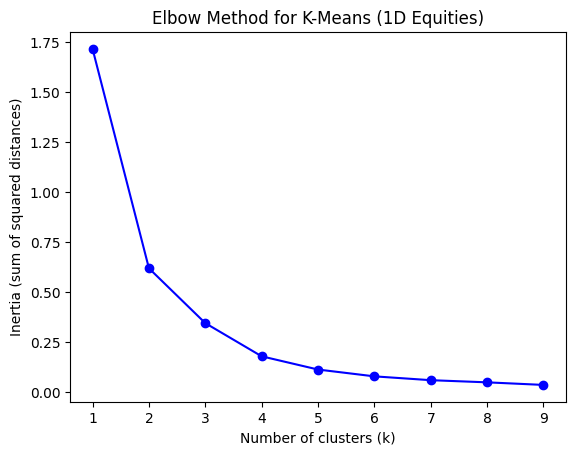

In [55]:
# Suppose df_equity has columns ["hand", "equity"]
equities = df_equity["equity"].values.reshape(-1, 1)  # shape (169, 1)

inertias = []
K_range = range(1, 10)  # test 1 to 9 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(equities)
    inertias.append(kmeans.inertia_)

plt.plot(K_range, inertias, "bo-")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (sum of squared distances)")
plt.title("Elbow Method for K-Means (1D Equities)")
plt.show()